SVR
===

**Autores:** Edélio Gabriel Magalhães de Jesus e Mateus de Jesus Mendes

# Introdução

Este *Jupyter Notebook* tem por objetivo implementar o algoritmo SVR para induzir um modelo a partir dos elementos do *dataset* `xtb_dataset.csv`.

## Fundamentação Teórica

### **Support Vector Machine: Uma Visão Geral**

![gif](https://miro.medium.com/v2/resize:fit:1100/format:webp/0*2-EExC6mYeEMvtrw.gif)

*Support Vector Machine* (SVM) é um algoritmo de aprendizado supervisionado inicialmente desenvolvido para classificação binária. Seu objetivo é encontrar o hiperplano ótimo que separa os dados de duas classes em um espaço de $n$ dimensões. Esse “ótimo” não significa apenas separar corretamente, mas sim maximizar a margem, isto é, a distância entre a fronteira de decisão e os pontos mais próximos a ela **\[[1, 2, 3, 4]()\]**. Esse processo de maximização tem suporte da Teoria de Aprendizado Estatístico **\[[4, 5]()\]**.

Esses pontos de cada classe que ficam mais próximos do hiperplano recebem o nome de vetores de suporte (*support vectors*) e são os elementos fundamentais que definem a solução final **\[[1, 2, 3]()\]**.  

Embora tenha surgido para problemas binários **\[[4]()\]**, o SVM pode ser estendido a classificação multiclasse. As duas estratégias mais comuns são **\[[6]()\]**:  
- **One-vs-Rest (OvR)**: treina um classificador para cada classe contra todas as outras.  
- **One-vs-One (OvO)**: treina classificadores para cada par de classes e usa votação para decidir a predição final.  

Com o tempo, o conceito foi ampliado: atualmente o SVM é considerado uma família de modelos baseados nessa mesma ideia de margem máxima, mas aplicados a diferentes contextos (classificação linear, não linear, regressão e até detecção de anomalias) **\[[6]()\]**.  

No **scikit-learn**, as principais variantes são:  
- **`SVC`** – *Support Vector Classification*, usado em classificação (linear ou com kernels).  
- **`LinearSVC`** – Versão otimizada para problemas lineares de alta dimensionalidade.  
- **`NuSVC`** – Alternativa ao `SVC` que usa o parâmetro `nu` em vez de `C` para controlar o número de vetores de suporte.  
- **`SVR`** – *Support Vector Regression*, aplica o mesmo princípio à regressão.  
- **`OneClassSVM`** – Usado para detecção de anomalias/outliers. 


Neste notebook, implementaremos o algoritmo **`SVR`** em um modelo para resolver a tarefa de **regressão supervisionada**.

# Metodologia

### Importações

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.exceptions import ConvergenceWarning

from optuna import create_study
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from optuna.trial import FixedTrial
from optuna.exceptions import TrialPruned
from optuna import load_study

import shap

import warnings

### Definições Globais

Definições de parâmetros globais usados ao longo desse *Jupyter Notebook*, a fim de assegurar clareza metodológica e reprodutibilidade:

In [2]:
RANDOM_SEED = 88
PATH = '../dataset_processing/xtb_dataset.csv'
TRAIN_SIZE = 0.8
STUDY_NAME = 'svr'

### Leitura dos Dados

Leitura do *dataset*:

In [3]:
df = pd.read_csv('../../dataset_processing/xtb_dataset.csv')

X = df.drop(columns=['Delta'])
y = df['Delta']

### Pré-processamento dos Dados

Divisão do *dataset* em subconjuntos de dados de treino e teste, considerando as *features* e o *target*:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_SEED)

### Treino & Otimização de Hiperparâmetros

Definição de classe para aplicação do método de redução de dimensionalidade VIF (*Variance Inflation Factor*):

In [5]:
class VIFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10.0):
        self.thresh = thresh

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X).copy()
        self.n_features_in_ = X_df.shape[1]
        self.features_ = list(X_df.columns)

        while True:
            vif = pd.Series(
                [
                    variance_inflation_factor(X_df.values, i)
                    for i in range(X_df.shape[1])
                ],
                index=X_df.columns
            )

            max_vif = vif.replace([np.inf, -np.inf], np.nan).max()

            if max_vif is not None and max_vif > self.thresh:
                drop_col = vif.idxmax()
                X_df = X_df.drop(columns=drop_col)
                self.features_.remove(drop_col)
            else:
                break

        self.features_ = np.array(self.features_, dtype=int)
        return self

    def transform(self, X):
        X = np.asarray(X)
        return X[:, self.features_]

Função para instanciar o modelo com todos os hiperparâmetros e tratamentos a serem usados pelo `optuna`:

In [6]:
def inst_svr(trial, n_features):

    kernel = trial.suggest_categorical(
        "kernel", ["linear", "rbf", "poly"]
    )

    # Parâmetros comuns
    params = {
        "C": trial.suggest_float("C", 1e-1, 1e2, log=True),
        "epsilon": trial.suggest_float("epsilon", 1e-2, 1.0, log=True),
        "kernel": kernel,
        "max_iter": 500_000
    }

    # Parâmetros específicos por kernel
    if kernel in ["rbf", "poly"]:
        params["gamma"] = trial.suggest_float(
            "gamma", 1e-3, 10.0, log=True
        )
    else:
        params["gamma"] = "scale"

    if kernel == "poly":
        params.update({
            "degree": trial.suggest_int("degree", 2, 4),
            "coef0": trial.suggest_float("coef0", 0.0, 1.0)
        })

    # Espaço de pré-processamento condicionado ao kernel
    if kernel == "linear":
        preprocessing_options = [
            None, "std", "VT", "RFE", "VIF", "PCA"
        ]

    elif kernel == "rbf":
        preprocessing_options = [
            "std", "VT", "PCA"
        ]

    else:   # poly
        preprocessing_options = [
            "std", "VT", "PCA", "VIF"
        ]

    pre_processing = trial.suggest_categorical(
        "pre_processing", preprocessing_options
    )

    steps = []

    # Normalização
    if pre_processing is not None or kernel in ["rbf", "poly"]:
        steps.append(("scale", StandardScaler()))

    # Variance Threshold
    if pre_processing == "VT":
        threshold = trial.suggest_float(
            "variance_threshold", 0.0, 0.1
        )
        steps.append((
            "vt", VarianceThreshold(threshold)
        ))

    # PCA
    elif pre_processing == "PCA":
        max_comp = min(n_features, 50)
        n_comp = trial.suggest_int(
            "pca_components", 2, max_comp
        )
        steps.append((
            "pca", PCA(n_components=n_comp)
        ))

    # RFE (apenas para kernel linear)
    elif pre_processing == "RFE":
        n_sel = trial.suggest_int(
            "rfe_features", 2, min(50, n_features)
        )
        estimator = LinearSVR(
            dual="auto",
            max_iter=10_000
        )
        steps.append((
            "rfe", RFE(
                estimator=estimator,
                n_features_to_select=n_sel
            )
        ))

    # VIF (apenas para espaço linear)
    elif pre_processing == "VIF":
        vif_thresh = trial.suggest_float(
            "vif_threshold", 5.0, 20.0
        )
        steps.append((
            "vif", VIFSelector(thresh=vif_thresh)
        ))

    # Modelo final
    steps.append(("svr", SVR(**params)))

    model = make_pipeline(*[s[1] for s in steps])

    return model

Função objetivo para validação cruzada:

In [7]:
def objective_function(trial, X, y, NUM_FOLDS=5):
    n_features = X.shape[1]
    cv = KFold(
        n_splits=NUM_FOLDS,
        shuffle=True,
        random_state=RANDOM_SEED
    )

    rmse_folds = []

    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        model = inst_svr(trial, n_features=n_features)

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = root_mean_squared_error(y_test, y_pred)

        rmse_folds.append(rmse)

        trial.report(np.mean(rmse_folds), step=i + 1)
        if trial.should_prune():
            raise TrialPruned()

    return float(np.mean(rmse_folds))

In [ ]:
def nested_cv_fold(fold_idx, X, y, outer_splits, inner_splits, n_trials, pasta_estudos):
    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=RANDOM_SEED)

    for fold, (idx_train, idx_test) in enumerate(outer_cv.split(X, y)):
        if fold != fold_idx:
            continue

        print(f"\nFold externo {fold + 1}/{outer_splits}")

        X_train, X_test = X.iloc[idx_train], X.iloc[idx_test]
        y_train, y_test = y.iloc[idx_train], y.iloc[idx_test]

        db_path = os.path.join(
            pasta_estudos,
            f"{STUDY_NAME}_fold_{fold + 1}.db"
        )

        def inner_objective(trial):
            return objective_function(
                trial,
                X_train,
                y_train,
                NUM_FOLDS=inner_splits
            )

        study = create_study(
            study_name=f"{STUDY_NAME}_fold_{fold + 1}",
            direction="minimize",
            sampler=TPESampler(seed=RANDOM_SEED),
            pruner=HyperbandPruner(
                min_resource=1,
                max_resource=inner_splits,
                reduction_factor=2
            ),
            storage=f"sqlite:///{db_path}",
            load_if_exists=True
        )

        study.optimize(
            inner_objective,
            n_trials=n_trials,
            n_jobs=1,
            show_progress_bar=False
        )

        print("Melhores hiperparâmetros encontrados:")
        print(study.best_params)

        best_model = inst_svr(
            FixedTrial(study.best_params),
            n_features=X_train.shape[1]
        )

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            best_model.fit(X_train, y_train)
            y_pred = best_model.predict(X_test)
            rmse_test = root_mean_squared_error(y_test, y_pred)

        print(f"RMSE de teste externo (fold {fold + 1}): {rmse_test:.4f}")
        return rmse_test

In [9]:
def nested_cv(X, y, outer_splits=5, inner_splits=3, n_trials=200, studies_folder="optuna_svr_studies"):
    os.makedirs(studies_folder, exist_ok=True)
    outer_scores = []

    for fold in range(outer_splits):
        rmse_fold = nested_cv_fold(
            fold_idx=fold,
            X=X,
            y=y,
            outer_splits=outer_splits,
            inner_splits=inner_splits,
            n_trials=n_trials,
            studies_folder=studies_folder
        )
        outer_scores.append(rmse_fold)

    outer_scores = np.array(outer_scores)

    print("\n========================")
    print("Resultados do Nested CV:")
    print(f"RMSE médio: {outer_scores.mean():.4f}")
    print(f"Desvio padrão: {outer_scores.std():.4f}")
    print("========================")

    return outer_scores

Execução dos estudos de otimização de hiperparâmetros do `optuna`:

> **📌 Observação:** O seguinte código está comentado como célula Markdown por apresentar elevado custo computacional. Desse modo, é recomendada execução do *script* `SVR.py` utilizando computação de alto desempenho (HPC) a fim de garantir eficiência e estabilidade computacional na execução dos estudos de otimização. Após isso, basta o diretório `svr_optuna_studies` para o mesmo diretório desse *Jupyter Notebook* e executar as células seguintes.

---
```python
results = nested_cv(X_train, y_train, outer_splits=5, inner_splits=3, n_trials=200)
```
---

Acesso aos estudos de otimização, para extração dos melhores valores dos hiperparâmetros e o desempenho obtido:

In [10]:
studies_folder = "optuna_svr_studies"
db_files = [f for f in os.listdir(studies_folder) if f.endswith(".db")]

print("Arquivos .db encontrados:")
for f in db_files:
    print("-", f)

Arquivos .db encontrados:
- svr_fold_1.db
- svr_fold_2.db
- svr_fold_3.db
- svr_fold_4.db
- svr_fold_5.db


Melhores hiperparâmetros obtidos durante a otimização:

In [11]:
results = []

for file in db_files:
    path = os.path.join(studies_folder, file)
    study_name = file.replace('.db', '')
    
    try:
        study = load_study(study_name=study_name, storage=f"sqlite:///{path}")
        best_trial = study.best_trial
        
        print(f"##### {study_name} #####")
        print(f"  Melhor valor: {best_trial.value:.7f}")
        print(f"  Parâmetros: {best_trial.params}\n")
        
        results.append({
            "fold": study_name,
            "best_value": best_trial.value,
            "params": best_trial.params
        })
    except Exception as e:
        print(f"Não foi possível carregar {study_name}: {e}")

# Exibe melhores resultados
if results:
    df_results = pd.DataFrame(results)
    display(df)
    print(f"RMSE médio: {np.mean(df_results['best_value']):.7f}")
    print(f"Desvio padrão: {np.std(df_results['best_value']):.7f}")
else:
    print("Nenhum estudo pôde ser carregado.")

##### svr_fold_1 #####
  Melhor valor: 0.0024441
  Parâmetros: {'kernel': 'linear', 'C': 0.45219264599903675, 'epsilon': 0.010051590731139846, 'pre_processing': 'std'}

##### svr_fold_2 #####
  Melhor valor: 0.0023234
  Parâmetros: {'kernel': 'linear', 'C': 31.763319760217268, 'epsilon': 0.01000511276335077, 'pre_processing': 'VT', 'variance_threshold': 0.03463868459240337}

##### svr_fold_3 #####
  Melhor valor: 0.0021351
  Parâmetros: {'kernel': 'linear', 'C': 13.978181360804484, 'epsilon': 0.010033199456911295, 'pre_processing': 'std'}

##### svr_fold_4 #####
  Melhor valor: 0.0023382
  Parâmetros: {'kernel': 'linear', 'C': 78.47774511744822, 'epsilon': 0.010005575858956959, 'pre_processing': 'std'}

##### svr_fold_5 #####
  Melhor valor: 0.0022725
  Parâmetros: {'kernel': 'linear', 'C': 0.33553306592241144, 'epsilon': 0.010029713755060234, 'pre_processing': 'VT', 'variance_threshold': 0.08070001471255434}



,Dipole,E_HOMO,E_LUMO,gap_HOMO-LUMO,ZPE,H,U,U0,G,Delta
0,0.727,-10.6203,-2.7950,-7.8253,0.154214,-27.917739,-27.918683,-28.080950,-27.959630,-12.397982
1,1.905,-10.4336,-2.2949,-8.1387,0.199866,-28.104404,-28.105348,-28.313524,-28.146070,-12.165407
2,4.475,-10.5746,-6.9494,-3.6252,0.120064,-27.272560,-27.273504,-27.400818,-27.312535,-13.078113
3,2.100,-9.8173,-5.5314,-4.2859,0.177677,-27.068399,-27.069343,-27.254803,-27.108720,-13.224129
4,0.872,-9.9722,-6.6172,-3.3550,0.133244,-24.148876,-24.149821,-24.292155,-24.192788,-16.186776
...,...,...,...,...,...,...,...,...,...,...
129152,4.710,-11.3840,-7.8335,-3.5505,0.121817,-26.808903,-26.809847,-26.939965,-26.851229,-13.538966
129153,4.996,-10.8793,-7.1097,-3.7696,0.141742,-28.278349,-28.279293,-28.428099,-28.317523,-12.050832
129154,3.973,-10.9497,-7.7346,-3.2151,0.124894,-24.819326,-24.820270,-24.952019,-24.858199,-15.526912
129155,0.918,-10.2869,-1.8611,-8.4258,0.195977,-30.002576,-30.003520,-30.208931,-30.047056,-10.270000


RMSE médio: 0.0023027
Desvio padrão: 0.0001007


Desempenho do melhor modelo obtido:

In [12]:
# df já contém os melhores trials de cada fold
best_fold = df_results.loc[df_results['best_value'].idxmin()]  # menor RMSE
print("Melhor fold:", best_fold['fold'])
print("Melhor desempenho (RMSE):", best_fold['best_value'])
print("Melhores parâmetros:", best_fold['params'])

Melhor fold: svr_fold_3
Melhor desempenho (RMSE): 0.0021350836565697424
Melhores parâmetros: {'kernel': 'linear', 'C': 13.978181360804484, 'epsilon': 0.010033199456911295, 'pre_processing': 'std'}


### Teste

Treino e teste finais para avaliação do melhor modelo obtido:

In [13]:
# Modelo SVR com os melhores parâmetros
svr_model = SVR(
    kernel='linear',
    C=13.978181360804484,
    epsilon=0.010033199456911295
)

# Pipeline completo
final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("estimator", svr_model)
])

# Treino
final_pipeline.fit(X_train, y_train)

# Avaliação final no conjunto de teste
y_pred = final_pipeline.predict(X_test)
rmse_teste = root_mean_squared_error(y_test, y_pred)

print("RMSE do melhor modelo:", rmse_teste)

RMSE do melhor modelo: 0.0025626251769323666


# Resultados

O melhor modelo induzido a partir do algoritmo SVR durante a otimização de hiperparâmetros do `optuna` obteve $\mathrm{RMSE}$ de $\approx 0.0021$, dotado dos seguintes hiperparâmetros tabulados e com o conjunto de dados submetido unicamente à normalização padrão.

| Hiperparâmetros | Valor                  |
|-----------------|------------------------|
| `C`             | $13.978181360804484$   |
| `coef0`         | $0$                    |
| `degree`        | $3$                    |
| `epsilon`       | $0.010033199456911295$ |
| `gamma`         | `scale`                |
| `kernel`        | `linear`               |
| `max_iter`      | $-1$                   |

Por fim, ao desenvolver o teste final, o modelo induzido com os hiperparâmetros supracitados obteve $\mathrm{RMSE}$ de $\approx 0.0026$, objetivamente maior, mas com mesma ordem de grandeza.

# SHAP

Para analisar a interpretabilidade do modelo vencedor encontrado pelo *Optuna*, é necessário carregá-lo a partir do arquivo de estudo utilizando a função `load_study()`.

> **📌 Observação importante:** O *SHAP* não aceita um *pipeline* completo como entrada, ele requer um modelo final ou uma função de predição. Por isso, cria-se um *trial* “falso” (`FixedTrial`) com os melhores hiperparâmetros para instanciar o pipeline vencedor.

Além disso, o modelo não é definido apenas pelos hiperparâmetros do algoritmo (`SVR`), mas também inclui todas as etapas de pré-processamento do pipeline, como normalização, redução de dimensionalidade ou seleção de *features*. Essas transformações devem ser aplicadas corretamente antes de calcular os valores de SHAP, garantindo que a explicação reflita exatamente como o modelo processa os dados.

In [ ]:
# Extrair os componentes já ajustados
scaler = final_pipeline.named_steps["scaler"]
svr_model = final_pipeline.named_steps["estimator"]

# Aplicar as transformações (usando os objetos já fitados)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

# Explainer rápido para SVR linear
explainer = shap.LinearExplainer(svr_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)
shap_values_exp = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test,
    feature_names=X_test.columns
)

### *Summary Plot*

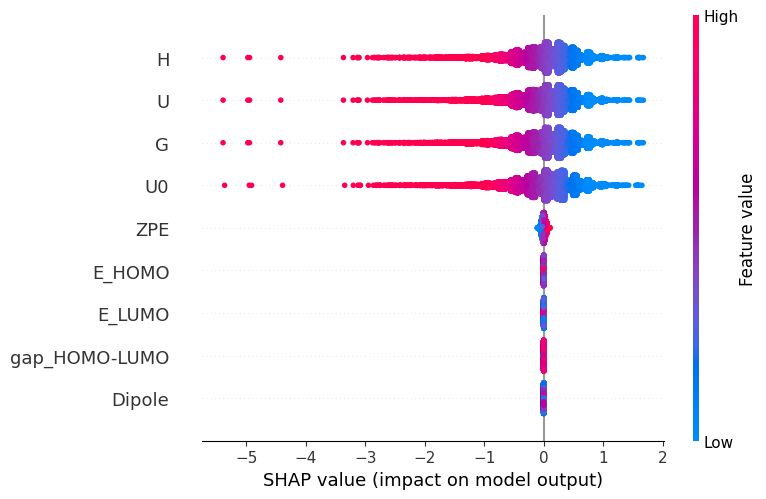

In [25]:
shap.summary_plot(shap_values_exp, features=X_test_scaled)

O gráfico acima é um SHAP *summary plot*, uma forma de visualizar a importância e o efeito das variáveis em um modelo preditivo.  

Cada ponto representa uma observação (amostra do conjunto de dados), e sua posição no eixo horizontal indica o impacto da *feature* no *output* do modelo** — isto é, o quanto aquela variável contribuiu para aumentar ou diminuir a predição.

O gráfico acima representa o impacto das três *features* — `G`, `ZPE` e `Dipole` — sobre a saída do modelo, medido pelos valores SHAP (*SHapley Additive exPlanations*).  
Cada ponto representa uma amostra, com a cor indicando o valor da *feature* (rosa = alto, azul = baixo).

**Análise geral**

- **Eixo X (SHAP value)**: mostra o quanto cada *feature* contribui para aumentar (valores positivos) ou diminuir (valores negativos) a predição do modelo.
- **Eixo Y (features)**: ordena as variáveis por importância média (impacto absoluto dos valores SHAP).
- **Cores**: representam o valor real da *feature* — tons quentes (rosa/vermelho) indicam valores altos, e tons frios (azul) indicam valores baixos.

**Interpretação Detalhada**
1. `H`, `U`, `G` e `U0`
- Essas quatro features concentram praticamente todo o poder explicativo do modelo, destacando-se de forma nítida em relação às demais.
- Observa-se uma ampla dispersão de valores SHAP, majoritariamente negativos para valores altos das variáveis (tons rosados) e positivos para valores baixos (tons azulados).
- Esse padrão indica uma relação inversa consistente: aumentos em entalpia, energia interna, energia de Gibbs ou energia de referência tendem a reduzir a predição do modelo, enquanto valores menores dessas grandezas a elevam.
- A extensão horizontal dos pontos sugere que o SVR captura efeitos não lineares relevantes, mesmo mantendo uma estrutura informacional concentrada em poucas variáveis.

2. `ZPE`
- Apresenta impacto reduzido, com valores SHAP fortemente concentrados em torno de zero.
- As variações dessa feature não produzem alterações sistemáticas na saída do modelo, indicando baixa contribuição preditiva no regime analisado.

3. `E_HOMO`, `E_LUMO`, `gap_HOMO–LUMO` e `Dipole`
- Essas variáveis eletrônicas exibem impacto marginal, sem padrão direcional claro e com dispersão mínima ao longo do eixo SHAP.
- Mesmo quando assumem valores extremos, sua influência sobre a predição permanece praticamente nula, sugerindo irrelevância estrutural para a tarefa de regressão.

O modelo SVR fundamenta suas previsões quase exclusivamente em variáveis termodinâmicas globais, enquanto propriedades eletrônicas e finas — como energias orbitais, *gap* e momento dipolar — exercem papel residual. Isso indica que o processo aprendido está associado a uma dinâmica energética macroscópica, e não a detalhes da estrutura eletrônica molecular.

***Insight* científico**  
A dominância de `H`, `U`, `G` e `U0` revela que o SVR internalizou uma relação energética essencial, possivelmente vinculada à estabilidade termodinâmica ou ao balanço energético do sistema. A irrelevância das variáveis eletrônicas sugere que, no espaço de dados considerado, esses efeitos são de segunda ordem ou já estão implicitamente incorporados nas grandezas termodinâmicas, reforçando a coerência física do modelo e sua capacidade de capturar o mecanismo dominante subjacente ao alvo previsto.

As indicações apresentadas pelo SHAP podem ser confirmadas por meio de uma nova previsão, mas somente com as *features* que o SHAP apresenta como as mais relevantes.

In [26]:
# Modelo SVR com os melhores parâmetros
svr_model = SVR(
    kernel='linear',
    C=13.978181360804484,
    epsilon=0.010033199456911295
)

# Pipeline completo
final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("estimator", svr_model)
])

# Treino
final_pipeline.fit(X_train[['U', 'H', 'G', 'U0']], y_train)

# Avaliação final no conjunto de teste
y_pred = final_pipeline.predict(X_test[['U', 'H', 'G', 'U0']])
rmse_teste = root_mean_squared_error(y_test, y_pred)

print("RMSE do melhor modelo:", rmse_teste)

RMSE do melhor modelo: 0.0027874527774297574


### *Bar Plot*

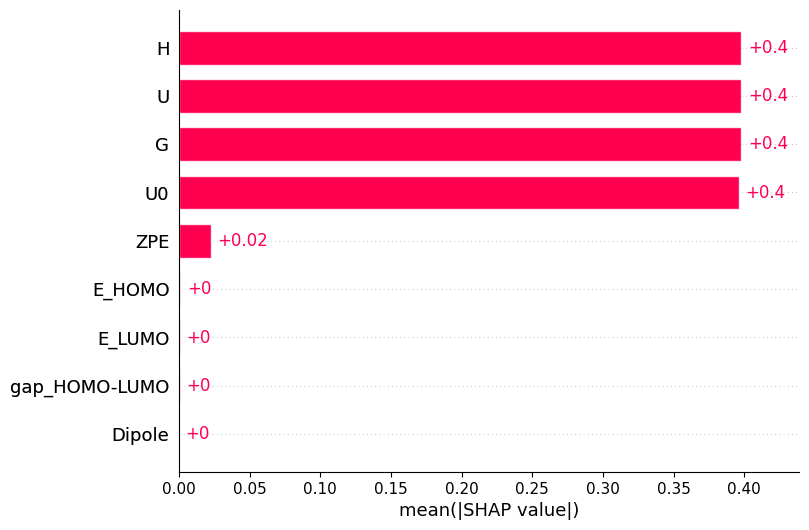

In [27]:
shap.plots.bar(shap_values_exp)

O gráfico acima mostra a importância média das variáveis no modelo, calculada pela média dos valores absolutos de SHAP (`mean(|SHAP value|)`).  
Ele representa, em termos quantitativos, o quanto cada *feature* contribui em média para as variações das previsões.

`Estrutura do gráfico`
- **Eixo X:** magnitude média dos valores SHAP — quanto maior, maior o impacto da *feature* no resultado.  
- **Eixo Y:** lista das *features* avaliadas.  
- **Cor e anotação à direita:** indicam o valor numérico do impacto médio.

**Interpretação Detalhada**

1. `H`, `U`, `G` e `U0`
- Essas quatro variáveis exibem valores médios praticamente idênticos de $\mathrm{|SHAP|} (\approx 0.40)$, formando um bloco claramente dominante.
- A equivalência de magnitude indica que o modelo não privilegia uma única grandeza energética, mas distribui sua capacidade explicativa de forma quase simétrica entre elas.
- Em termos práticos, variações comparáveis em `H`, `U`, `G` e `U0` produzem impactos médios semelhantes na saída do modelo, reforçando a ideia de que o SVR opera sobre um subespaço energético redundante e altamente correlacionado.

2. `ZPE`
- Apresenta um valor médio de $\mathrm{|SHAP|}$ significativamente menor $(\approx 0.02)$, situando-se várias ordens de magnitude abaixo das variáveis dominantes.
- Sua contribuição para a predição é marginal, indicando que o modelo a utiliza apenas de forma residual, possivelmente como ajuste local ou ruído estatístico.

3. `E_HOMO`, `E_LUMO`, `gap_HOMO–LUMO` e `Dipole`
- Essas variáveis apresentam contribuição média praticamente nula $(\approx 0)$.
- Do ponto de vista global, o modelo ignora completamente essas *features*, evidenciando que propriedades eletrônicas finas não são informativas para a tarefa de regressão no regime de dados considerado.

Esse resultado reforça, de maneira quantitativa, o observado no summary plot: o modelo aprendeu uma estrutura energética global, enquanto descarta sistematicamente informações eletrônicas e contribuições de menor escala energética.

***Insight* Científico**

A equivalência entre `H`, `U`, `G` e `U0` sugere que o SVR explora um *manifold* energético redundante, no qual diferentes descritores termodinâmicos carregam essencialmente a mesma informação física relevante para o alvo. A irrelevância de ZPE, momento dipolar e parâmetros eletrônicos indica que, neste conjunto de dados, o fenômeno modelado é governado por balanços energéticos macroscópicos, e não por detalhes da estrutura eletrônica molecular, conferindo robustez física e interpretabilidade ao modelo.

### *Waterfall Plot*

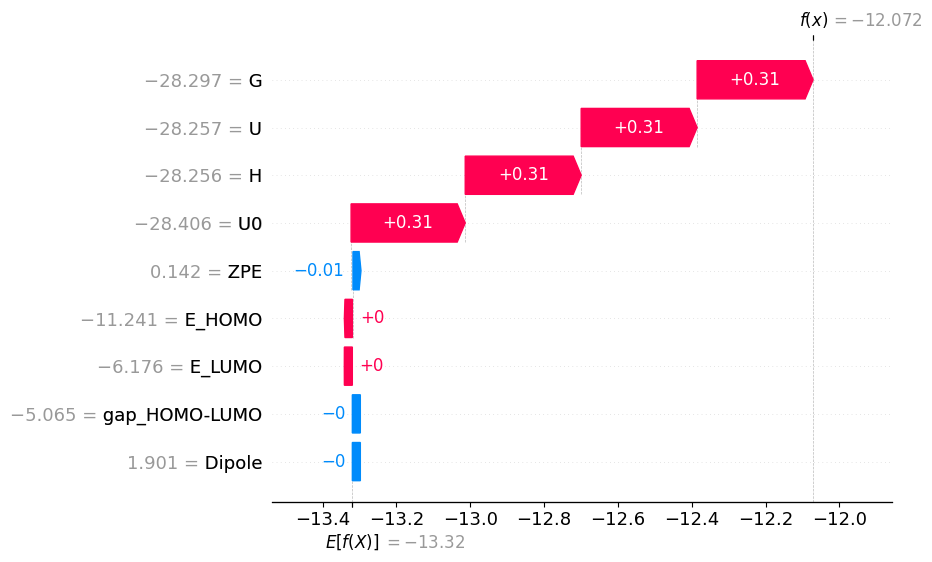

In [28]:
shap.plots.waterfall(shap_values_exp[0])

O gráfico acima é um *waterfall plot* do SHAP, que mostra como cada *feature* contribui individualmente para a predição de uma amostra específica do modelo.

**Estrutura do gráfico**

- $\mathbb{E}[f(X)] = −13.32$ → é o valor médio das predições do modelo (baseline).  
- $f(x)=−12.07$ → é a predição final para esta amostra.  
- As barras mostram como cada *feature* desloca o valor da predição em relação à média.  
  - **Azul**: contribuição negativa (reduz o valor previsto).  
  - **Vermelho**: contribuição positiva.

**Interpretação Detalhada**

1. `H`, `U`, `G` e `U0`
- Essas quatro variáveis são responsáveis praticamente por todo o deslocamento da predição em relação ao valor médio do modelo.
- Cada uma contribui com um impacto positivo e de magnitude semelhante (≈ +0.31), evidenciando novamente a simetria informacional entre essas grandezas energéticas.
- Para esta instância, os valores relativamente baixos dessas variáveis posicionam a predição acima de $\mathbb{E}[f(X)]$, em total concordância com o padrão observado no *summary plot*: valores menores de `H`, `U`, `G` e `U0` tendem a aumentar a saída prevista.

2. `ZPE`
- Apresenta um impacto marginal e negativo $(\approx −0.01)$, praticamente irrelevante frente às contribuições das variáveis dominantes.
- Sua influência atua apenas como um ajuste residual, sem alterar de forma significativa o resultado final.

3. `E_HOMO`, `E_LUMO`, `gap_HOMO–LUMO` e `Dipole`
- As contribuições dessas variáveis são nulas ou numericamente desprezíveis.
- Mesmo para esta observação específica, elas não exercem papel efetivo na decisão do modelo.

A predição final $f(x)=−12.07$ resulta do deslocamento positivo do valor esperado $\mathbb{E}[f(X)] = −13.32$, causado quase exclusivamente pelas variáveis `H`, `U`, `G` e `U0`.

As demais features atuam de forma residual ou são completamente ignoradas pelo modelo, não influenciando de maneira mensurável o valor previsto.

***Insight* Científico**

O *waterfall plot* confirma, em nível local, a estrutura global já identificada: o SVR fundamenta suas decisões em um conjunto compacto e redundante de descritores termodinâmicos, enquanto descarta propriedades eletrônicas e correções de menor escala. A contribuição equilibrada de `H`, `U`, `G` e `U0` reforça a ideia de que o modelo opera sobre um *manifold* energético compartilhado, no qual diferentes grandezas carregam essencialmente a mesma informação física relevante para a variável alvo.

# Conclusão

A análise do modelo SVR, fundamentada nas métricas de desempenho e nas interpretações via SHAP, conduz a uma conclusão objetiva e coerente com os resultados observados para o ElasticNet.

O SVR otimizado pelo Optuna apresentou alto desempenho preditivo, com $\mathrm{RMSE}$ de aproximadamente $0.0021$ durante a otimização e $0.0026$ no teste final, mantendo a mesma ordem de grandeza e indicando boa capacidade de generalização. O aumento moderado do erro no conjunto de teste sugere ausência de *overfitting* relevante e estabilidade do modelo frente a dados não vistos.

A seleção do *kernel* linear, combinada a um valor elevado de `C` e a um `epsilon` pequeno, revela que o modelo opera essencialmente sob uma estrutura linear global, com sensibilidade controlada aos desvios em torno da margem. Embora o SVR permita, em princípio, modelagem não linear, os dados e o processo de otimização conduziram a uma solução linearmente dominante.

Essa interpretação é corroborada pelas análises de SHAP. O *summary plot* e o *bar plot* mostram que a maior parte da capacidade explicativa do modelo está concentrada em um subconjunto reduzido de *features*, principalmente `H`, `U`, `G` e `U0`. As demais variáveis apresentam contribuições marginais, com valores de SHAP próximos de zero, indicando sinal preditivo fraco ou redundante.

A direção dos efeitos é estável: valores elevados das *features* dominantes tendem a contribuir negativamente para a predição, deslocando-a abaixo da média global. O *waterfall plot* confirma que, em nível local, essas mesmas variáveis explicam quase integralmente o valor final predito, assegurando consistência entre as interpretações global e individual.

Em síntese, o SVR otimizado alcança seu desempenho elevado ao explorar uma subestrutura de baixa dimensionalidade e essencialmente linear do espaço de atributos. A análise via SHAP explicita essa estrutura interna, fornecendo suporte empírico para decisões de simplificação do modelo e para a compreensão clara dos *trade-offs* entre desempenho máximo e parcimônia.

# Referências

[1] RASCHKA, Sebastian; MIRJALILI, Vahid. Python machine learning: machine learning and deep learning with Python, scikit-learn, and TensorFlow 2. 3. ed. [S.l.]: Packt, [s.d.].

[2] STATQUEST WITH JOSH STARMER. Support Vector Machines part 1 (of 3): main ideas!!!. [S.l.]: YouTube, [s.d.]. Disponível em: https://youtu.be/efR1C6CvhmE?si=yfCtwqnRPt1FEO1O. Acesso em: 24 out. 2025.

[3] HASHTAG PROGRAMAÇÃO. SVM (Support Vector Machine) – algoritmos de aprendizado de máquinas. [S.l.]: YouTube, [s.d.]. Disponível em: https://youtu.be/Y-WFZd9_gtE?si=5CMIM6krA9kQBNNy. Acesso em: 24 out. 2025.

[4] FACELI, Katti; LORENA, Ana Carolina et al. Inteligência artificial: uma abordagem de aprendizado de máquina. 2. ed. Rio de Janeiro: LTC, 2021. 400 p.

[5] WIKIPEDIA. Teoria de aprendizado estatístico. [S.l.], [s.d.]. Disponível em: https://en.wikipedia.org/wiki/Statistical_learning_theory. Acesso em: 24 out. 2025.

[6] SCIKIT-LEARN. Support Vector Machines. [S.l.], [s.d.]. Disponível em: https://scikit-learn.org/stable/modules/svm.html#svm. Acesso em: 24 out. 2025.

[7] LIGEIRO, Gabriel. Como interpretar seu modelo de machine learning usando SHAP values. Medium, 5 dez. 2020. Disponível em: https://gabrielligeiro.medium.com/como-interpretar-seu-modelo-de-machine-learning-usando-shap-values-2c61c0d26317. Acesso em: 24 out. 2025.

[8] LUNDBERG, Scott; LEE, Su-In. SHAP – Welcome to the SHAP documentation. 2018. Disponível em: https://shap.readthedocs.io/en/latest/. Acesso em: 24 out. 2025.

[9] AWAN, Abid Ali. Uma introdução aos valores SHAP e à interpretabilidade do aprendizado de máquina. DataCamp, 11 set. 2024. Disponível em: https://www.datacamp.com/pt/tutorial/introduction-to-shap-values-machine-learning-interpretability. Acesso em: 24 out. 2025.